## Import libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.ensemble import RandomForestRegressor

## Load and save data

In [30]:
# Load and save the train file
train_file = 'data/train.csv'
train_df = pd.read_csv(train_file)

## Data preprocessing

In [31]:
# Replace Date column by Week and Year column because we get one data per week
train_df['Date'] = pd.to_datetime(train_df['Date'])
train_df['Week'] = train_df.Date.apply(lambda x: x.weekofyear)
train_df['Year'] = train_df.Date.apply(lambda x: x.year)
train_df = train_df.drop(['Date'], axis=1)

# Set missing value to 0
train_df.fillna(0, inplace=True)

# Set negative sales to 0
train_df.loc[train_df['Weekly_Sales'] < 0, 'Weekly_Sales'] = 0

# In competition evaluation, weights in WMAE are 5 if week is holiday, 1 otherwise
train_df['IsHoliday'].replace([False,True], [1,5], inplace = True)

train_df.head()

,Store,Dept,Weekly_Sales,IsHoliday,Week,Year
0,1,1,24924.50,1,5,2010
1,1,1,46039.49,5,6,2010
2,1,1,41595.55,1,7,2010
3,1,1,19403.54,1,8,2010
4,1,1,21827.90,1,9,2010


In [32]:
# create a copy of this dataframe to use it later in this original preprocessed form if needed
train_df2 = train_df.copy()

## Add columns for benchmark models : Average, last week sales and last year sales 

In [19]:
# Add all weeks average columns group by store and department
train_df2['Average_Sales'] = train_df2.groupby(['Store','Dept'])['Weekly_Sales'].transform(np.mean)    
    
# Get Last Week Sales and Last Year Sales by shifting values
# https://stackoverflow.com/questions/26280345/pandas-shift-down-values-by-one-row-within-a-group    
train_df2['Last_Week_Sales'] = train_df2.groupby(['Store','Dept'])['Weekly_Sales'].transform(lambda x:x.shift())
train_df2['Last_Year_Sales'] = train_df2.groupby(['Store','Dept','Week'])['Weekly_Sales'].transform(lambda x:x.shift())

# print some lines of train df2
train_df2[(train_df2['Store']==1) & (train_df2['Dept']==4)].head()

,Store,Dept,Weekly_Sales,IsHoliday,Week,Year,Average_Sales,Last_Week_Sales,Last_Year_Sales
429,1,4,39954.04,1,5,2010,36964.154476,NaN,NaN
430,1,4,35351.21,5,6,2010,36964.154476,39954.04,NaN
431,1,4,36826.95,1,7,2010,36964.154476,35351.21,NaN
432,1,4,34660.16,1,8,2010,36964.154476,36826.95,NaN
433,1,4,38086.19,1,9,2010,36964.154476,34660.16,NaN


## Dataframe with only weeks to predict

In [7]:
# We select the 36 last weeks of the data set
# its in 2012, from Week 8 to Week 43
predict_df = train_df2[(train_df2['Week'] >= 8) & (train_df2['Year'] == 2012)]

## Display benchmark models for our 36 forecasted weeks

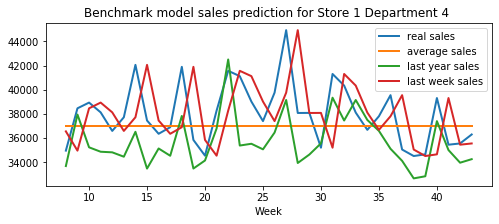

In [8]:
# Pick one store and department number to display
store = 1
department = 4        
# create a temporary data_df with data from our store and dept
data_df = predict_df.copy()
data_df.set_index('Week', inplace=True)
data_df = data_df[(data_df.Store == store)&(data_df.Dept == department)]

# Plot the 3 benchmark-models and real sales
plt.figure(figsize=(8,3))
data_df['Weekly_Sales'].plot(label='real sales', lw=2)
data_df['Average_Sales'].plot(label='average sales', lw=2)
data_df['Last_Year_Sales'].plot(label='last year sales', lw=2)
data_df['Last_Week_Sales'].plot(label='last week sales', lw=2)
plt.title(label='Benchmark model sales prediction for Store {} Department {} '.format(str(store),str(department)))
plt.legend(loc='best')
plt.show()

## WMAE function

In [11]:
# Define a function to compute WMAE metric for our benchmarks model
def compute_wmae(benchmark):
    # Create some lists to compute WMAE for all of our series
    total_sum_weights=[]
    total_sum_weighted_error=[]

    # loop to compute WMAE for each store and departement
    for store in predict_df['Store'].unique():
        for dept in predict_df['Dept'].unique():

            # create a temporary data_df with data from the store and department in the loop
            data_df = predict_df.copy()
            data_df = data_df[(data_df.Store == store)&(data_df.Dept == dept)]

            # We only take into account series with at least one sales data
            if len(data_df['Weekly_Sales'].unique())>0:
                data_df['weighted_error'] = data_df['IsHoliday'] * abs(data_df['Weekly_Sales']-data_df[benchmark])
                sum_weights = data_df.IsHoliday.sum()
                sum_weighted_error = data_df.weighted_error.sum()

                # compute WMAE for this store and dept
                wmae = (1/sum_weights) * sum_weighted_error

                if str(wmae) != 'nan':
                    # We could print the WMAE for each store and dept by uncomment the following line
                    # print('Weighted mean absolute error (WMAE) for Store {} Dept {} = {}'.format(str(store),str(dept),str(wmae)))

                    # append sum_weights and sum_weighted error for this store to compute the global WMAE at the end
                    total_sum_weights.append(sum_weights)
                    total_sum_weighted_error.append(sum_weighted_error)

    global_wmae = (1/sum(total_sum_weights)) * sum(total_sum_weighted_error)
    return print('Global Weighted mean absolute error (WMAE) for these predicted series with {} = {}'.format(str(benchmark1), str(global_wmae)))

## Compute WMAE for our 3 benchmarks models

In [12]:
benchmark1='Average_Sales'
compute_wmae(benchmark1)

Global Weighted mean absolute error (WMAE) for these predicted series with Average_Sales = 2334.3418377510097


In [13]:
benchmark2='Last_Week_Sales'
compute_wmae(benchmark2)

Global Weighted mean absolute error (WMAE) for these predicted series with Average_Sales = 1685.5684100213596


In [14]:
benchmark3='Last_Year_Sales'
compute_wmae(benchmark3)

Global Weighted mean absolute error (WMAE) for these predicted series with Average_Sales = 1789.9510619835048


## Random Forest Regressor Model

In [33]:
# Remove benchmark models from train_df2
train_df2 = train_df2.drop(['Average_Sales','Last_Week_Sales','Last_Year_Sales'], axis=1)
train_df2.head()

,Store,Dept,Weekly_Sales,IsHoliday,Week,Year
0,1,1,24924.50,1,5,2010
1,1,1,46039.49,5,6,2010
2,1,1,41595.55,1,7,2010
3,1,1,19403.54,1,8,2010
4,1,1,21827.90,1,9,2010


In [22]:
# Create some lists to compute WMAE for all of our series
total_sum_weights=[]
total_sum_weighted_error=[]
week = 8

# Create a train dataframe with data from 2010 to week 8 in 2012
train2010 = train_df2[train_df2['Year'] == 2010]
train2011 = train_df2[train_df2['Year'] == 2011]
train2012 = train_df2[(train_df['Year'] == 2012) & (train_df2['Week'] < week)]
train = train2010.append(train2011).append(train2012)

# Create a test dataframe with data from week 8 in 2012 (to get our wanted 36 weeks)
test = train_df2[(train_df2['Week'] >= week) & (train_df2['Year'] == 2012)]

Weighted mean absolute error (WMAE) for Store 1 Dept 1 = 3275.0028674999935


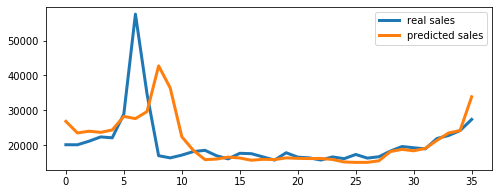

Weighted mean absolute error (WMAE) for Store 1 Dept 2 = 1382.0975600000002


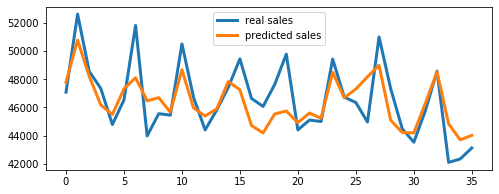

Weighted mean absolute error (WMAE) for Store 1 Dept 3 = 2634.845775


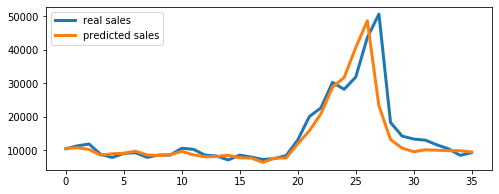

Weighted mean absolute error (WMAE) for Store 1 Dept 4 = 2091.6695275000125


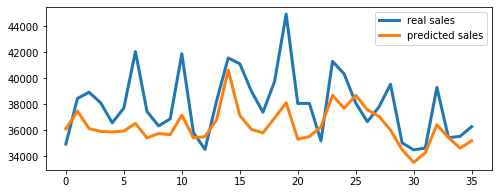

Weighted mean absolute error (WMAE) for Store 1 Dept 5 = 2715.80347


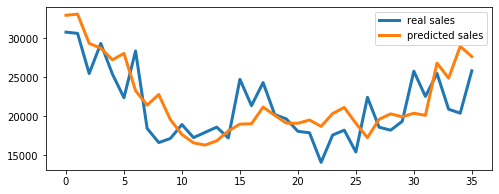

Weighted mean absolute error (WMAE) for Store 1 Dept 6 = 1292.7513349999997


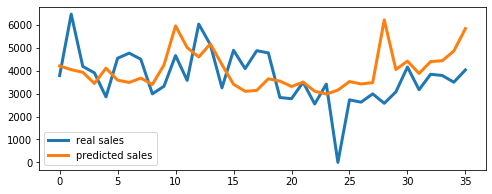

Weighted mean absolute error (WMAE) for Store 1 Dept 7 = 3025.7260399999936


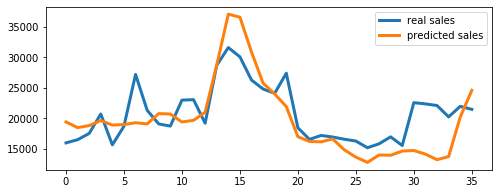

Weighted mean absolute error (WMAE) for Store 1 Dept 8 = 3904.847412499998


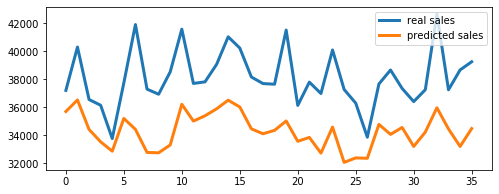

Weighted mean absolute error (WMAE) for Store 1 Dept 9 = 4736.611812499998


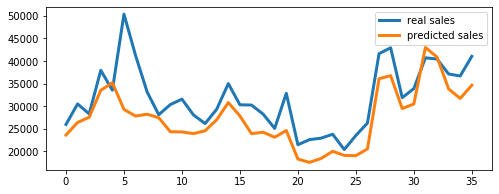

Global Weighted mean absolute error (WMAE) for these predicted series = 1555.322000844991


In [23]:
# loop to train a model, make a prediction and compute WMAE for each store and departement
for store in train_df2['Store'].unique():
    for dept in train_df2['Dept'].unique():
        
        # Select train and test dataframe for the wanted store and dept
        train_sd = train[(train.Store == store)&(train.Dept == dept)]
        test_sd = test[(test.Store == store)&(test.Dept == dept)]
        
        # Keep all data except Sales for xtrain and xtest
        xtrain = train_sd.drop(['Weekly_Sales'], axis=1)
        xtest = test_sd.drop(['Weekly_Sales'], axis=1)
        
        # Keep only Sales for ytrain and ytest
        ytrain = train_sd['Weekly_Sales'].values
        ytest = test_sd['Weekly_Sales'].values

        # Create a RandomForestRegressor model
        rfr = RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=0)
        
        # train the Random Forst model if there is data for training
        if len(xtrain)>0:           
            rfr.fit(xtrain, ytrain)
        
            # make a prediction if there is an expected output
            if len(xtest)>0:
                pred = rfr.predict(xtest)

                # if there is an output, compute WMAE metric
                if len(pred)>0:
                    xtest['weighted_error'] = xtest.IsHoliday * abs(ytest-pred)
                    sum_weights = xtest.IsHoliday.sum()
                    sum_weighted_error = xtest.weighted_error.sum()
                    wmae = (1/sum_weights) * sum_weighted_error

                    if str(wmae) != 'nan':
                        # plot some firsts departments predictions as examples
                        if (store == 1) & (dept<10):
                            print('Weighted mean absolute error (WMAE) for Store {} Dept {} = {}'.format(str(store),str(dept),str(wmae)))
                            plot_df = pd.DataFrame()
                            plot_df['predicted_sales'] = pred
                            plot_df['real_sales']=ytest
                            plt.figure(figsize=(8,3))
                            plot_df['real_sales'].plot(label='real sales', lw=3)
                            plot_df['predicted_sales'].plot(label='predicted sales', lw=3)
                            plt.legend()
                            plt.show()

                        total_sum_weights.append(sum_weights)
                        total_sum_weighted_error.append(sum_weighted_error)
                        
# Global WMAE for our model will be printed at the end
global_wmae = (1/sum(total_sum_weights)) * sum(total_sum_weighted_error)
print('Global Weighted mean absolute error (WMAE) for these predicted series = {}'.format(str(global_wmae)))

## Try to improve this RF model by adding features

### Add MarkDown1 Feature

In [41]:
features_file = 'data/features.csv'
features_df = pd.read_csv(features_file)

train_file = 'data/train.csv'
train_df = pd.read_csv(train_file)

In [42]:
train_df = train_df.merge(features_df, how='left')

# Replace Date column by Week and Year column because we get one data per week
train_df['Date'] = pd.to_datetime(train_df['Date'])
train_df['Week'] = train_df.Date.apply(lambda x: x.weekofyear)
train_df['Year'] = train_df.Date.apply(lambda x: x.year)
train_df = train_df.drop(['Date'], axis=1)

# Set missing value to 0
train_df.fillna(0, inplace=True)

# Set negative sales to 0
train_df.loc[train_df['Weekly_Sales'] < 0, 'Weekly_Sales'] = 0

# In competition evaluation, weights in WMAE are 5 if week is holiday, 1 otherwise
train_df['IsHoliday'].replace([False,True], [1,5], inplace = True)

# MarkDown Nan = O, Others = 1
list=['MarkDown1','MarkDown2','MarkDown3','MarkDown4','MarkDown5']
for i in list:
    train_df.loc[train_df[i] != 0, i] = 1
    
train_df.replace('NaN', 0, inplace = True)

# Keep only MarkDown1 feature
train_df = train_df.drop(['Temperature','Fuel_Price','MarkDown2','MarkDown3','MarkDown4','MarkDown5','CPI','Unemployment'], axis=1)
train_df.head()

,Store,Dept,Weekly_Sales,IsHoliday,MarkDown1,Week,Year
0,1,1,24924.50,1,0.0,5,2010
1,1,1,46039.49,5,0.0,6,2010
2,1,1,41595.55,1,0.0,7,2010
3,1,1,19403.54,1,0.0,8,2010
4,1,1,21827.90,1,0.0,9,2010


Repeat the same previous step with a dataframe now containing Markdown1 data

In [43]:
# create a copy of this dataframe to use it later in this original preprocessed form if needed
train_df3 = train_df.copy()

In [44]:
# Create some lists to compute WMAE for all of our series
total_sum_weights=[]
total_sum_weighted_error=[]
week = 8

# Create a train dataframe with data from 2010 to week 8 in 2012
train2010 = train_df3[train_df3['Year'] == 2010]
train2011 = train_df3[train_df3['Year'] == 2011]
train2012 = train_df3[(train_df3['Year'] == 2012) & (train_df3['Week'] < week)]
train = train2010.append(train2011).append(train2012)

# Create a test dataframe with data from week 8 in 2012 (to get our wanted 36 weeks)
test = train_df3[(train_df3['Week'] >= week) & (train_df3['Year'] == 2012)]

In [45]:
# loop to train a model, make a prediction and compute WMAE for each store and departement
for store in train_df3['Store'].unique():
    for dept in train_df3['Dept'].unique():
        
        # Select train and test dataframe for the wanted store and dept
        train_sd = train[(train.Store == store)&(train.Dept == dept)]
        test_sd = test[(test.Store == store)&(test.Dept == dept)]
        
        # Keep all data except Sales for xtrain and xtest
        xtrain = train_sd.drop(['Weekly_Sales'], axis=1)
        xtest = test_sd.drop(['Weekly_Sales'], axis=1)
        
        # Keep only Sales for ytrain and ytest
        ytrain = train_sd['Weekly_Sales'].values
        ytest = test_sd['Weekly_Sales'].values

        # Create a RandomForestRegressor model
        rfr = RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=0)
        
        # train the Random Forst model if there is data for training
        if len(xtrain)>0:           
            rfr.fit(xtrain, ytrain)
        
            # make a prediction if there is an expected output
            if len(xtest)>0:
                pred = rfr.predict(xtest)

                # if there is an output, compute WMAE metric
                if len(pred)>0:
                    xtest['weighted_error'] = xtest.IsHoliday * abs(ytest-pred)
                    sum_weights = xtest.IsHoliday.sum()
                    sum_weighted_error = xtest.weighted_error.sum()
                    wmae = (1/sum_weights) * sum_weighted_error

                    if str(wmae) != 'nan':
                        total_sum_weights.append(sum_weights)
                        total_sum_weighted_error.append(sum_weighted_error)
                        
# Global WMAE for our model will be printed at the end
global_wmae = (1/sum(total_sum_weights)) * sum(total_sum_weighted_error)
print('Global Weighted mean absolute error (WMAE) for these predicted series = {}'.format(str(global_wmae)))

Global Weighted mean absolute error (WMAE) for these predicted series = 1566.9760873539208


We get a little worse results by adding this Markdown1 feature

### Add Size feature

In [47]:
stores_file = 'data/stores.csv'
stores_df = pd.read_csv(stores_file)

train_file = 'data/train.csv'
train_df = pd.read_csv(train_file)

In [48]:
train_df = train_df.merge(stores_df, how='left')

# Replace Date column by Week and Year column because we get one data per week
train_df['Date'] = pd.to_datetime(train_df['Date'])
train_df['Week'] = train_df.Date.apply(lambda x: x.weekofyear)
train_df['Year'] = train_df.Date.apply(lambda x: x.year)
train_df = train_df.drop(['Date'], axis=1)

# Set missing value to 0
train_df.fillna(0, inplace=True)

# Set negative sales to 0
train_df.loc[train_df['Weekly_Sales'] < 0, 'Weekly_Sales'] = 0

# In competition evaluation, weights in WMAE are 5 if week is holiday, 1 otherwise
train_df['IsHoliday'].replace([False,True], [1,5], inplace = True)

train_df = train_df.drop(['Type'], axis=1)  
train_df.head()

,Store,Dept,Weekly_Sales,IsHoliday,Size,Week,Year
0,1,1,24924.50,1,151315,5,2010
1,1,1,46039.49,5,151315,6,2010
2,1,1,41595.55,1,151315,7,2010
3,1,1,19403.54,1,151315,8,2010
4,1,1,21827.90,1,151315,9,2010


Repeat the same previous step with a dataframe now containing Size data

In [49]:
# create a copy of this dataframe to use it later in this original preprocessed form if needed
train_df4 = train_df.copy()

In [50]:
# Create some lists to compute WMAE for all of our series
total_sum_weights=[]
total_sum_weighted_error=[]
week = 8

# Create a train dataframe with data from 2010 to week 8 in 2012
train2010 = train_df4[train_df4['Year'] == 2010]
train2011 = train_df4[train_df4['Year'] == 2011]
train2012 = train_df4[(train_df4['Year'] == 2012) & (train_df4['Week'] < week)]
train = train2010.append(train2011).append(train2012)

# Create a test dataframe with data from week 8 in 2012 (to get our wanted 36 weeks)
test = train_df4[(train_df4['Week'] >= week) & (train_df4['Year'] == 2012)]

In [51]:
# loop to train a model, make a prediction and compute WMAE for each store and departement
for store in train_df4['Store'].unique():
    for dept in train_df4['Dept'].unique():
        
        # Select train and test dataframe for the wanted store and dept
        train_sd = train[(train.Store == store)&(train.Dept == dept)]
        test_sd = test[(test.Store == store)&(test.Dept == dept)]
        
        # Keep all data except Sales for xtrain and xtest
        xtrain = train_sd.drop(['Weekly_Sales'], axis=1)
        xtest = test_sd.drop(['Weekly_Sales'], axis=1)
        
        # Keep only Sales for ytrain and ytest
        ytrain = train_sd['Weekly_Sales'].values
        ytest = test_sd['Weekly_Sales'].values

        # Create a RandomForestRegressor model
        rfr = RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=0)
        
        # train the Random Forst model if there is data for training
        if len(xtrain)>0:           
            rfr.fit(xtrain, ytrain)
        
            # make a prediction if there is an expected output
            if len(xtest)>0:
                pred = rfr.predict(xtest)

                # if there is an output, compute WMAE metric
                if len(pred)>0:
                    xtest['weighted_error'] = xtest.IsHoliday * abs(ytest-pred)
                    sum_weights = xtest.IsHoliday.sum()
                    sum_weighted_error = xtest.weighted_error.sum()
                    wmae = (1/sum_weights) * sum_weighted_error

                    if str(wmae) != 'nan':
                        total_sum_weights.append(sum_weights)
                        total_sum_weighted_error.append(sum_weighted_error)
                        
# Global WMAE for our model will be printed at the end
global_wmae = (1/sum(total_sum_weights)) * sum(total_sum_weighted_error)
print('Global Weighted mean absolute error (WMAE) for these predicted series = {}'.format(str(global_wmae)))

Global Weighted mean absolute error (WMAE) for these predicted series = 1555.1955996298918


We get a slightly better result than the first model, but with results so close I think better to select the first model with less data